In [1]:
#devtools::install_github("immunogenomics/lisi")

### Compare the LISI integration metrics across methods

In [2]:
library(lisi)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
adata_metadata = read.csv("06_adata_metadata_for_LISI.csv")

In [4]:
adata_metadata %>% head()

,X,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,⋯,disease_binary,decade,age_group,leiden_harmony,umap_no_harmony_1,umap_no_harmony_2,umap_harmony_1,umap_harmony_2,umap_scvi_1,umap_scvi_2
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Fetal-1st-LV-0315-2-run1n2:CTTGCTAACATA,18,Penn:Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,⋯,N,18,fetal,0,-2.251575,12.451655,5.101506,4.0594400,6.699205,5.719560
2,Fetal-1st-LV-0315-2-run1n2:CTAAACGAATGG,18,Penn:Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,⋯,N,18,fetal,0,-1.968003,13.490361,5.526382,0.7283053,7.720970,8.365377
3,Fetal-LV-18wk-e2-run1n2:TGTAGTATCTAC,18,Penn:Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,⋯,N,18,fetal,2,-3.351723,9.581577,2.608839,12.3908825,7.441147,5.582879
4,Fetal-Atria-18wk:CGAGACGCGCCC,18,Penn:Penn_F1,female,Atria,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,⋯,N,18,fetal,0,-2.330004,12.052362,4.211123,4.8854733,7.163264,5.483727
5,Fetal_LV_18wk_e1-run1n2:GCCTGCTTATGA,18,Penn:Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,⋯,N,18,fetal,0,-2.342471,11.179408,6.025790,4.4289800,6.936304,4.768302
6,Fetal-1st-LV-0315-1-run1n2:CTAACGCTCGCG,18,Penn:Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,⋯,N,18,fetal,0,-1.894425,13.540942,4.568750,1.6023388,7.694353,8.512167


In [5]:
# number of studies
length(unique(adata_metadata$study))

[1] 11

In [6]:
compute_LISI <- function(adata_metadata, UMAP_1_name, UMAP_2_name, integration_method) {

    # compute the LISI for study and cell type
    # inputs are the adata_metadata, which should have all of the columns
    # UMAP_1_name and UMAP_2_name are the strings for the UMAP1 and UMAP2 coordinates 
    # integration method is the name of the integration method (e.g.  "harmony")

    # filter the metadata
    X <- adata_metadata[ , c(UMAP_1_name, UMAP_2_name)]
    meta_data <- adata_metadata[, c("study", "consistent_cell_type")]

    # compute the LISI for these two metadata columns
    res <- compute_lisi(X, meta_data, c("study", "consistent_cell_type"))

    # pivot this longer 
    res <- res %>% pivot_longer(cols = everything(), names_to = "category", values_to = "lisi")
    res$integration_method <- integration_method

    return(res)
}

In [7]:
no_integration_results <- compute_LISI(adata_metadata = adata_metadata,
                        UMAP_1_name = "umap_no_harmony_1", 
                        UMAP_2_name = "umap_no_harmony_2", 
                        integration_method = "no_integration")

In [8]:
harmony_results <- compute_LISI(adata_metadata = adata_metadata,
                        UMAP_1_name = "umap_harmony_1", 
                        UMAP_2_name = "umap_harmony_2", 
                        integration_method = "harmony")

In [9]:
scvi_results <- compute_LISI(adata_metadata = adata_metadata,
                        UMAP_1_name = "umap_scvi_1", 
                        UMAP_2_name = "umap_scvi_2", 
                        integration_method = "scvi")

### Plot the performance in terms of integration by study (higher is better) and integration by cell_type (lower is better)

In [10]:
combined_results <- rbind(no_integration_results, harmony_results)
combined_results <- rbind(combined_results, scvi_results)

In [11]:
combined_results$integration_method <- factor(combined_results$integration_method , c("no_integration", "scvi", "harmony"))

In [12]:
plots_dir <- "../../paper_figures/"

In [13]:
options(repr.plot.width = 15, repr.plot.height = 5)
p1 <- ggplot(data = combined_results, mapping = aes(x = lisi, fill = integration_method)) + 
    geom_density(alpha = 0.5) + 
    facet_wrap(~ category, scales = "free") + 
    theme_bw() +
    labs(x = "LISI Score", y = "Density", title = "Integration metric across methods") +
    theme(legend.position = "right") + 
    theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16),
         axis.text.y = element_text(size = 16),
         strip.text = element_text(size = 18))

ggsave(p1, filename = paste0(plots_dir, "snRNA_LISI_across_studies.pdf"), units = "in", width = 15, height = 5)

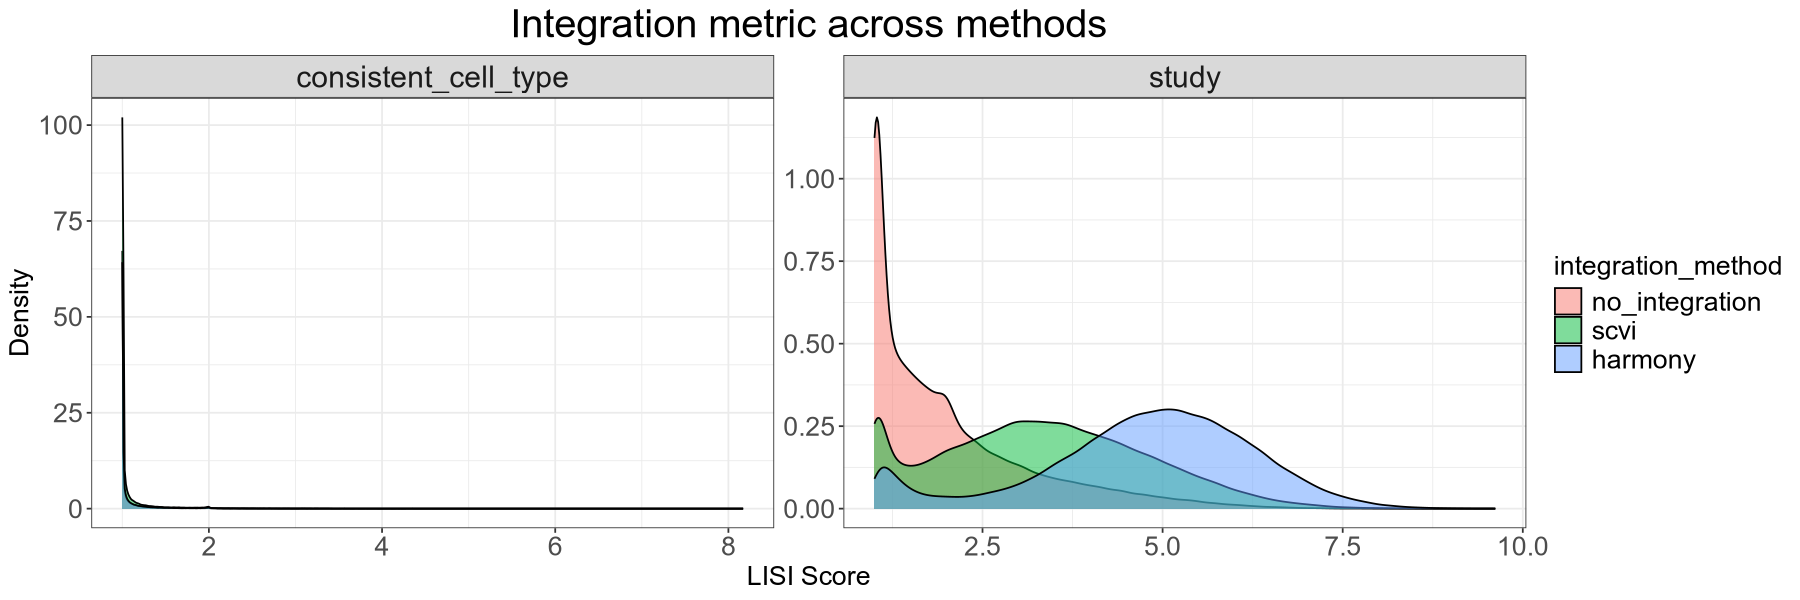

In [14]:
p1 

### Compare the runtimes

In [15]:
runtimes_df <- read.table("06_integration_runtimes.txt", header=TRUE)
runtimes_df

method,runtime_s
<chr>,<int>
harmony,31172
none,4410
scVI,8168


In [16]:
# convert runtime to hr 
runtimes_df$runtime_h <- runtimes_df$runtime_s / 3600

# set order
runtimes_df$method <- factor(runtimes_df$method, c("none", "scVI", "harmony"))

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6)

p2 <- ggplot(data = runtimes_df, mapping = aes(x = method, y = runtime_h, fill = method)) + 
geom_bar(stat = "identity") + theme_bw() + theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16),
         axis.text.y = element_text(size = 16),
	 strip.text = element_text(size = 18)) + labs(x = "integration method", y = "runtime (h)", 
                                                  title = "runtime across integration methods") 

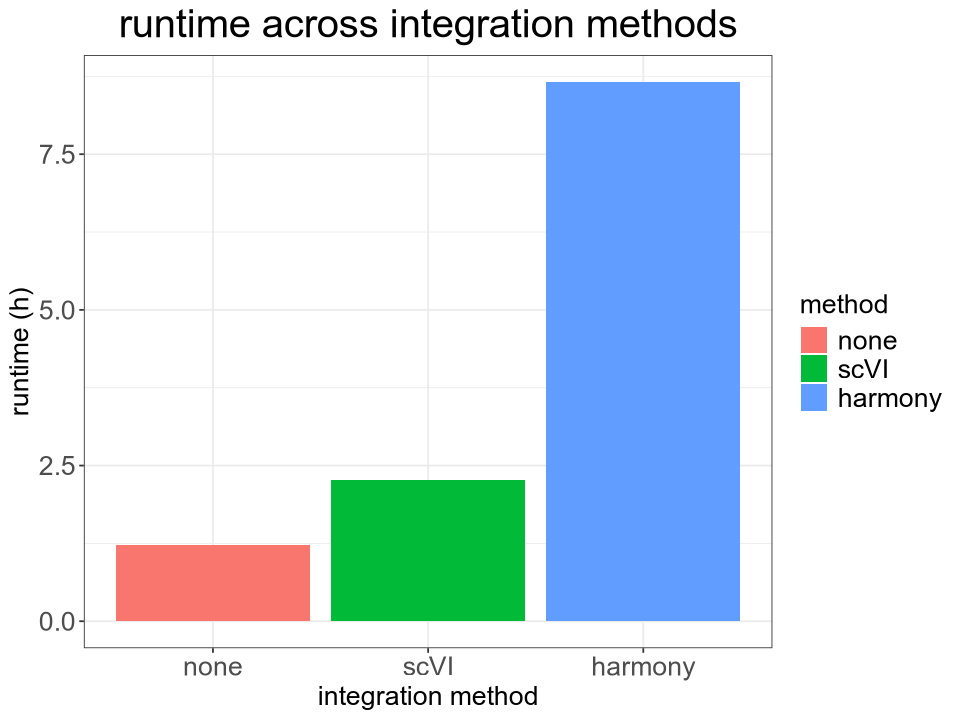

In [18]:
p2

In [19]:
ggsave(p2, filename = paste0(plots_dir, "snRNA_integration_runtimes.pdf"), units = "in", width = 15, height = 5)